In [126]:
import os
import math
import json
import igraph

import numpy as np
import pandas as pd
import networkx as nx

from time import time
from pprint import pprint

from itertools import groupby
from itertools import combinations

from collections import defaultdict

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.datasets.base import Bunch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import manhattan_distances

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering

from networkx.readwrite import json_graph

from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
from util import Ean
ean_checker = Ean()

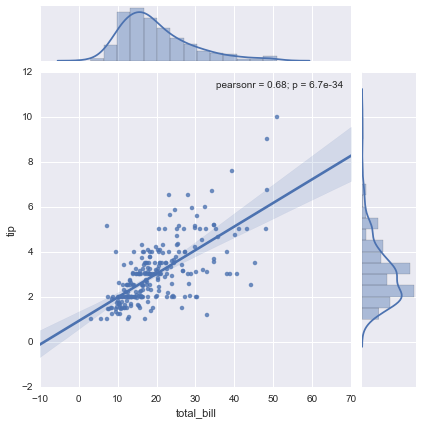

In [4]:
import seaborn as sns

# Load one of the data sets that come with seaborn
tips = sns.load_dataset("tips")

sns.jointplot("total_bill", "tip", tips, kind='reg');
 

In [5]:
def abs_dist(attr='price'):
    def _inner(a, b):
        return abs(a[attr] - b[attr])
    return _inner

In [6]:
def equal_dist(attr='name'):
    def _inner(a, b):
        if a[attr] == b[attr]:
            return 0.0
        else:
            return 1.0
    return _inner

In [7]:
class Distance:
    distances = [
        abs_dist(attr='price'),
        equal_dist(attr='name'),
    ]
    def __call__(self, a, b):
        distances = []
        for distance in self.distances:
            distances.append(distance(a, b))
        return np.array(distances)

## clean up prices

In [8]:
def convert_price(price):
    price = str(price)
    if ',' in price:
        if '.' in price:
            price = price.replace('.', '')
        price = price.replace(',', '.')
        
    if ' EUR' in price:
        price = price.replace(' EUR', '')

    try:
        return float(price)
    except ValueError:
        # print('<{}>'.format(price))
        return None

## read products feed

In [9]:
products = pd.read_csv('products.csv', error_bad_lines=False, converters={'price': convert_price})
products = products.drop('Unnamed: 0', 1)
products = products[~products.price.isnull()]
# list(products.columns)

//anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


## group by ean and get samples with at least 5 items

In [10]:
# dunno why this is so slow
# ean_grouped = products.groupby('ean').filter(lambda x: len(x) > 5)

In [124]:
[(key, list(items)) for key, items in groupby(zip(products.shop, products.ean)) if key[1] == 2998949375120]

[((98, 2998949375120),
  [(98, 2998949375120),
   (98, 2998949375120),
   (98, 2998949375120),
   (98, 2998949375120),
   (98, 2998949375120),
   (98, 2998949375120),
   (98, 2998949375120),
   (98, 2998949375120)])]

In [148]:
# select only eans which appear in more than 5 shops
shops_for_ean = defaultdict(set)
for ean, shop in zip(products.ean, products.shop):
    shops_for_ean[ean].add(shop)
#print(list(shops_for_ean.items())[:10])
good_eans = {ean for ean, shops in shops_for_ean.items() if len(shops) > 5}
sample_products = products[products.ean.isin(pd.Series(list(good_eans)).sample(n=10))]
#print(sample_products.shape)

In [138]:
good_eans = pd.Series(ean for ean, eans in groupby(candidate_eans) if len(list(eans)) > 1)
print(len(good_eans))
print(2998949375090 in good_eans)
print(2998949375120 in set(good_eans))
sample_products = products[products.ean.isin(good_eans.sample(n=10))]

0
False
False


ValueError: a must be greater than 0

In [118]:
print(2998949375090 in set(sample_products.ean))

False


## create sample dataset

In [149]:
dataset = Bunch()
dataset.data = sample_products
dataset.target = sample_products.ean
dataset.true_k = np.unique(dataset.target).shape[0]

In [150]:
dataset.data

,privateid,name,shortdescription,brand,ean,price,type,shop
9681,17327,Brother DCP-J4120DW MFP A3 Farb-Tinte USB2.0+W...,017327 - Brother DCP-J4120DW MFP A3 Farb-Tinte...,Brother,4977766736800,117.75,PC Hardware,600
9742,17327,Brother DCP-J4120DW MFP A3 Farb-Tinte USB2.0+W...,017327 - Brother DCP-J4120DW MFP A3 Farb-Tinte...,Brother,4977766736800,117.75,PC Hardware,601
9803,17327,Brother DCP-J4120DW MFP A3 Farb-Tinte USB2.0+W...,017327 - Brother DCP-J4120DW MFP A3 Farb-Tinte...,Brother,4977766736800,117.75,PC Hardware,602
11069,10001689,"Lexmark Ink 35, color",1801127H,Lexmark,734646957670,20.22,Flash Memory,705
11376,10002056,Canon Ink Cartridge BCI-3BK,0911009H,Canon,4960999865300,13.20,Flash Memory,705
11439,20024395,"Brother Toner, black",1062119H,Brother,4977766654180,40.73,Toner,705
11470,20023782,"HP Toner Cartridge, cyan",0180489H,Hewlett-Packard,882780459120,218.26,Toner,705
234666,70084,TP-Link Printserver TP-Link TL-PS310U 1xUSB Mu...,NaN,TP-Link,6935364031060,44.74,Computer & Software > PC Zubehör,1567
234687,54979,Brother Toner Brother TN-2110 HL-2140/2150N/2170W,NaN,Brother,4977766654180,47.50,Computer & Software > PC Zubehör,1567
234717,57914,Delock PCI Expr Card Delock 2x D-Sub9 ext + 1x...,NaN,Delock,4043619891290,31.06,Computer & Software > PC Zubehör,1567


## feature extraction

In [151]:
class EmptyFitMixin:
    def fit(self, x, y=None):
        return self

In [152]:
class ItemSelector(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def __init__(self, key):
        self.key = key

    def transform(self, df):
        values = np.array(df[self.key])
        return values.reshape(values.shape[0], 1)

In [153]:
class TextExtractor(BaseEstimator, TransformerMixin, EmptyFitMixin):
    """Extract the text from a product in a single pass.

    Takes a pandas dataframe and produces a series of texts
    from joined columns defined in `text_cols`.
    """
    def __init__(self, text_cols=['name', 'shortdescription', 'brand', 'type']):
        self.text_cols = text_cols
    
    def transform(self, data):
        def join(items):
            return ' '.join([str(item) for item in items])
        
        texts = data[self.text_cols].apply(join, axis=1)
        return texts

In [154]:
class CosineDistance(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        cosine_similarity = linear_kernel(X, X)
        return 1.0 - cosine_similarity

In [155]:
class NumericDistance(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        return manhattan_distances(X)

In [156]:
class CombineDistances(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        parts_num = X.shape[1] / X.shape[0]
        parts = np.split(X, parts_num, axis=1)
        # combine with euclidean distance
        return np.sqrt(np.sum(p**2 for p in parts))

In [157]:
simple_features = FeatureUnion(
    transformer_list=[

        # Pipeline for pulling features from the text columns
        ('text_tfidf', Pipeline([
            # Extract text data from products
            ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
            ('tfidf', TfidfVectorizer()),
            ('svd', TruncatedSVD(2)),
            ('normalizer', Normalizer(copy=False)),
        ])),

        # Pipeline for price
        ('price', Pipeline([
            ('selector', ItemSelector(key='price')),
        ])),
    ],
)

In [158]:
pipeline_simple = Pipeline([
    # Use FeatureUnion to extract features from text and price
    ('features', simple_features),
    # Use kmeans clustering on the combined features
    ('kmeans', KMeans(n_clusters=dataset.true_k, init='k-means++', max_iter=100, n_init=1)),
])

In [159]:
#pp = sns.pairplot(sproducts, hue="ean", vars=['text_1', 'text_2', 'price'])

In [160]:
distance_features = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            # Pipeline for pulling features from the text columns
            # and build a cosine distance matrix from it
            ('text_tfidf', Pipeline([
                ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
                ('tfidf', TfidfVectorizer()),
                ('tfidf_distance', CosineDistance()),
            ])),

            # Pipeline for price
            ('price', Pipeline([
                ('selector', ItemSelector(key='price')),
                ('price_distance', NumericDistance()),
                ('normalizer', Normalizer(copy=False)),
            ])),
        ],
    )),
    ('combine', CombineDistances()),
])

In [161]:
pipeline_distances = Pipeline([
    # Use FeatureUnion to combine the features from text and price
    ('distances', distance_features),
    # Use kmeans clustering on the combined features
    ('kmeans', KMeans(n_clusters=dataset.true_k, init='k-means++', max_iter=100, n_init=1)),
])

In [162]:
#X = pipeline_distances.transform(dataset.data)
#pp = sns.pairplot(sproducts, hue="ean", vars=['text_1', 'text_2', 'price'])

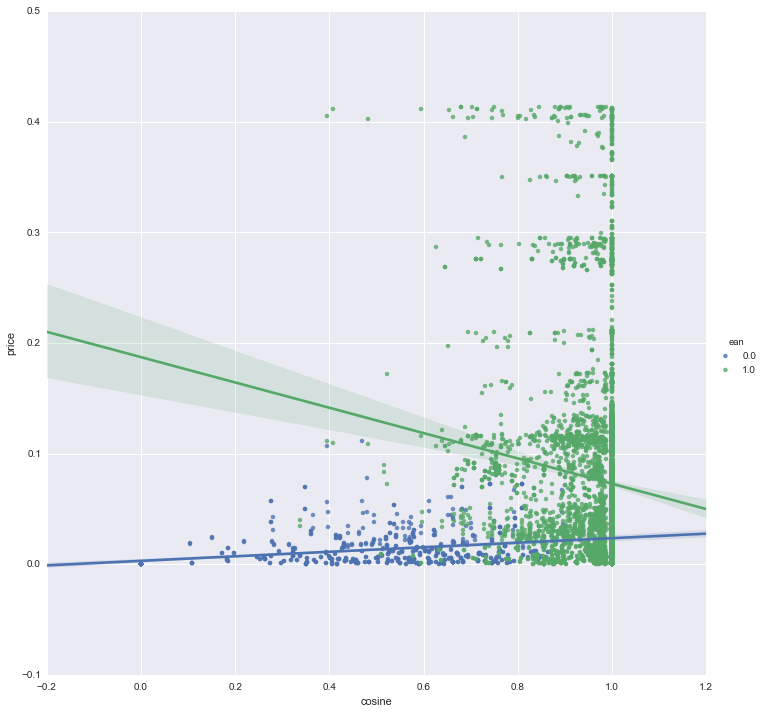

In [163]:
X_cosine_dist = pipeline_distances.steps[0][1].steps[0][1].transformer_list[0][1].fit_transform(dataset.data).flatten()
X_price_dist = pipeline_distances.steps[0][1].steps[0][1].transformer_list[1][1].transform(dataset.data).flatten()
X_ean_dist = NumericDistance().transform(ItemSelector(key='ean').transform(dataset.data)).flatten()
X_ean_dist[X_ean_dist > 0] = 1
df = pd.DataFrame({'cosine': X_cosine_dist, 'price': X_price_dist, 'ean': X_ean_dist})
#pp = sns.pairplot(df, hue="ean", vars=['cosine', 'price'], diag_kind="kde")
#sns.jointplot("cosine", "price", data=df, kind='scatter', size=10);
#sns.pairplot(df, x_vars=["cosine"], y_vars=["price"], hue="ean", size=10, kind="scatter")
sns.lmplot(x="cosine", y="price", hue="ean", data=df, size=10)

In [34]:
help(sns.jointplot)

Help on function jointplot in module seaborn.distributions:

jointplot(x, y, data=None, kind='scatter', stat_func=<function pearsonr at 0x109e5db70>, color=None, size=6, ratio=5, space=0.2, dropna=True, xlim=None, ylim=None, joint_kws=None, marginal_kws=None, annot_kws=None, **kwargs)
    Draw a plot of two variables with bivariate and univariate graphs.
    
    This function provides a convenient interface to the :class:`JointGrid`
    class, with several canned plot kinds. This is intended to be a fairly
    lightweight wrapper; if you need more flexibility, you should use
    :class:`JointGrid` directly.
    
    Parameters
    ----------
    x, y : strings or vectors
        Data or names of variables in ``data``.
    data : DataFrame, optional
        DataFrame when ``x`` and ``y`` are variable names.
    kind : { "scatter" | "reg" | "resid" | "kde" | "hex" }, optional
        Kind of plot to draw.
    stat_func : callable or None
        Function used to calculate a statistic ab

In [164]:
pipeline_dbscan = Pipeline([
    # Use FeatureUnion to combine the features from text and price
    ('distances', distance_features),
    # Use kmeans clustering on the combined features
    ('dbscan', SpectralClustering(n_clusters=dataset.true_k, eigen_solver='arpack')),
])

In [165]:
def evaluate_clustering(pipeline, dataset):
    pipeline.fit(dataset.data)
    #X = pipeline.transform(dataset.data)
    predicted = pipeline.fit_predict(dataset.data, dataset.target)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset.target, predicted))
    print("Completeness: %0.3f" % metrics.completeness_score(dataset.target, predicted))
    print("V-measure: %0.3f" % metrics.v_measure_score(dataset.target, predicted))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(dataset.target, predicted))
    #print("Silhouette Coefficient: %0.3f"
    #      % metrics.silhouette_score(X, predicted, sample_size=1000))

In [166]:
#%timeit pipeline_simple.fit_predict(dataset.data)

In [167]:
evaluate_clustering(pipeline_simple, dataset)

Homogeneity: 0.499
Completeness: 0.643
V-measure: 0.562
Adjusted Rand-Index: 0.248


In [168]:
evaluate_clustering(pipeline_distances, dataset)

Homogeneity: 0.941
Completeness: 0.955
V-measure: 0.948
Adjusted Rand-Index: 0.878


In [169]:
evaluate_clustering(pipeline_dbscan, dataset)

Homogeneity: 0.962
Completeness: 0.966
V-measure: 0.964
Adjusted Rand-Index: 0.909


//anaconda/lib/python3.4/site-packages/sklearn/cluster/spectral.py:425: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


## distances to graph

In [170]:
# calc distances
X = distance_features.fit_transform(dataset.data, dataset.target)

In [171]:
# convert distance matrix to graph
dt = [('distance', float)]
G = nx.from_numpy_matrix(X.view(dt))

In [172]:
# create node color lookup dict
eans = set(dataset.data.ean)
colors = [int(c.replace('#', '0x'), 16) for c in sns.color_palette("hls", len(eans)).as_hex()]
ean_colors = {e: c for e, c in zip(eans, colors)}
node_colors = dict(enumerate((ean_colors[ean] for ean in dataset.data.ean)))

## visualize distance graph with igraph and webgl

In [201]:
# create json representation of graph, reformat node format and add color to nodes
igraph_json = json_graph.node_link_data(G)
igraph_json['nodes'] = {n['id']: {'id': n['id'], 'color': node_colors[n['id']]} for n in igraph_json['nodes']}
# reduce number of edges and rename links to edges
#igraph_json['edges'] = [l for l in igraph_json['links'] if l['distance'] < 1.0 and l['distance'] > 0.1]
igraph_json['edges'] = [l for l in igraph_json['links'] if l['distance'] < 0.7 and l['distance'] > 0.0]
#igraph_json['edges'] = igraph_json['links']
len(igraph_json['edges'])

355

In [202]:
igraph.draw(igraph_json, size=(800, 600), directed=False)

## visualize distance graph with d3 and svg

In [203]:
# create json representation of graph, reformat node format and add color to nodes
d3_graph_json = json_graph.node_link_data(G)
d3_graph_json['nodes'] = [{'id': n['id'], 'color': node_colors[n['id']]} for n in d3_graph_json['nodes']]
pprint(d3_graph_json['nodes'][:2])
# filter links
d3_graph_json['links'] = [l for l in d3_graph_json['links'] if l['distance'] < 0.7 and l['distance'] > 0.0]
pprint(d3_graph_json['links'][:2])

# python json to javascript
from IPython.display import Javascript
#runs arbitrary javascript, client-side
Javascript("window.graph_json={};".format(json.dumps(d3_graph_json)))

[{'color': 14376791, 'id': 0}, {'color': 14376791, 'id': 1}]
[{'distance': 1.1102230246251565e-16, 'source': 0, 'target': 0},
 {'distance': 1.1102230246251565e-16, 'source': 0, 'target': 1}]


<IPython.core.display.Javascript object>

In [204]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [205]:
%%javascript
require(['d3'], function(d3){
  //a weird idempotency thing
  $("#chart1").remove();
  //create canvas
  var style = [
    '<style>',
    '.node {',
    '  stroke: #fff;',
    '  stroke-width: 1.5px;',
    '}',
    '.link {',
    '  stroke: #999;',
    '  stroke-opacity: .6;',
    '}',
    '</style>'
  ].join('\n');

  //element.append(style);
  element.append("<h1>distance graph</h1>")
  element.append("<div id='chart1'></div>");
        
  var width = 960,
    height = 500;

  var color = d3.scale.category20();

  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  var svg = d3.select("#chart1").append("svg")
    .attr("width", width)
    .attr("height", height);

  var graph = window.graph_json;

  force
    .nodes(graph.nodes)
    .links(graph.links)
    .start();

  var link = svg.selectAll(".link")
    .data(graph.links)
  .enter().append("line")
    .attr("class", "link")
    .style("stroke", "#999")
    .style("stroke-width", function(d) { return 1.0; });
//    .style("stroke-width", function(d) { return d.distance / 1.0; });

  var node = svg.selectAll(".node")
    .data(graph.nodes)
  .enter().append("circle")
    .attr("class", "node")
    .attr("r", 5)
    .style("fill", function(d) { return color(d.color); })
    .call(force.drag);

  node.append("title")
    .text(function(d) { return d.id; });

  force.on("tick", function() {
    link.attr("x1", function(d) { console.log('foobar: ' + d.source.x);return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node.attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; });
  });
});

<IPython.core.display.Javascript object>

## manual distance calculations

In [485]:
distance = Distance()
distances = []
for a, b in combinations(dataset.data, 2):
    pass
    #distances.append(distance(a, b))
len(distances)

0

In [102]:
dataset.data.ean.iloc[1]

2998949374840